### Survival Analysis of Dell Employees Using Lifelines & Various Modeling Approaches
##### Zane Harris, April 2016

In [1]:
# importing packages and creating a dataframe from employee data pulled in November of 2015
# Data has passed data accuracy tests, includes all hires from 03-21-2012 to present
# Dell has an average rehire rate of 11%

import datetime
import pandas as pd
import numpy as np
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.utils import survival_table_from_events
from lifelines import AalenAdditiveFitter, CoxPHFitter
import matplotlib.pyplot as plt
import matplotlib 
import patsy
import decimal

%matplotlib inline

df = pd.read_csv("C:\Users\Zane_Harris\Desktop\Survival_Nov15v.csv")

df.head()
df.count()
df.dtypes


BADGE                  int64
GENDER                object
HIRE_DATE             object
Duration               int64
age_at_hire            int64
COUNTRY               object
HIR_REH               object
GRADE_AT_HIRE         object
FUNCTION_AT_HIRE      object
CURRENT_FUNCTION      object
CURRENT_GRADE         object
Event                  int64
TERMINATION_CODE      object
TERMINATION_REASON    object
ACTION                object
DIT_FUNC_VP_NAME      object
DIT_2LVL_VP_NAME      object
dtype: object

In [2]:
#Realize that Gender[U] is significant because the employees we lack gender for are contract employees
#who live outside the US, contracts by nature end sooner (so I know the model 
#is successfully picking out those at risk lol) so I disregard that curve as a potential issue to explore

Z = patsy.dmatrix('GENDER + HIR_REH -1', df, return_type='dataframe')
Z.columns

aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
Z['T'] = df['Duration']/30
Z['E'] = df['Event']
aaf.fit(Z, 'T', event_col='E')


print aaf.cumulative_hazards_.head()

 [-----------------100%-----------------] 14905 of 14905 complete in 45.4 sec
          GENDER[F]  GENDER[M]  HIR_REH[T.REH]  baseline
0.033333   0.000266  -0.000089        0.000474  0.000177
0.066667   0.000539  -0.000084        0.000105  0.000454
0.100000   0.000837   0.000085        0.000107  0.000921
0.133333   0.001097   0.000161       -0.000026  0.001258
0.166667   0.001223   0.000110        0.000572  0.001333


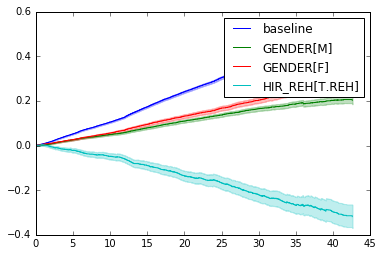

In [3]:
aaf.plot( columns=['baseline', 'GENDER[M]', 'GENDER[F]', 'HIR_REH[T.REH]' ])


In [4]:
# results show a better curve for rehires and men compared to women and first time hires

In [5]:
def bin_age(x):
    if(x == np.nan or x == None):
        return 'Null' 
        
    if x >= 60:
        return 'Baby Boomers 1'
    elif x >= 51:
        return 'Baby Boomers 2'
    elif x >= 42:
        return 'Gen X 1'
    elif x >= 35:
        return 'Gen X 2'
    elif x >= 25:
        return 'Millennial 1' 
    elif x >= 18:
        return 'Millennial 2'    
    else:
        return 'Gen Z'
    
df['Generation'] = df.age_at_hire.apply(bin_age)

df_dummy_generation = pd.get_dummies(df.Generation).rename(
    columns=lambda x: 'Generation_' + str(x)
)
df = df.join(df_dummy_generation)
df.head()

,BADGE,GENDER,HIRE_DATE,Duration,age_at_hire,COUNTRY,HIR_REH,GRADE_AT_HIRE,FUNCTION_AT_HIRE,CURRENT_FUNCTION,...,DIT_FUNC_VP_NAME,DIT_2LVL_VP_NAME,Generation,Generation_Baby Boomers 1,Generation_Baby Boomers 2,Generation_Gen X 1,Generation_Gen X 2,Generation_Gen Z,Generation_Millennial 1,Generation_Millennial 2
0,102,M,6/8/2015,144,48,USA,REH,II,IT,EN,...,"Smyth, Michael","Walsh, Paul",Gen X 1,0,0,1,0,0,0,0
1,1143,M,2/2/2015,270,53,USA,REH,IJ,EN,EN,...,"Gorakhpurwalla, Ashley","Haas, Marius",Baby Boomers 2,0,1,0,0,0,0,0
2,1306,M,7/28/2014,454,52,USA,REH,IH,PV,PV,...,"Maher, Tom","Schmitt, Doug",Baby Boomers 2,0,1,0,0,0,0,0
3,1353,M,9/14/2015,48,50,USA,REH,IF,ET,ET,...,"Gorakhpurwalla, Ashley","Haas, Marius",Gen X 1,0,0,1,0,0,0,0
4,1846,M,6/23/2014,489,56,USA,REH,IH,SE,SE,...,"Maher, Tom","Schmitt, Doug",Baby Boomers 2,0,1,0,0,0,0,0


In [6]:
A = patsy.dmatrix('Generation + HIR_REH -1', df, return_type='dataframe')
A.columns


aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
A['T'] = df['Duration']/30
A['E'] = df['Event']
aaf.fit(A, 'T', event_col='E')

 [-----------------100%-----------------] 14905 of 14905 complete in 81.5 sec


<lifelines.AalenAdditiveFitter: fitted with 51623 observations, 36718 censored>

In [7]:
print aaf.cumulative_hazards_.head()

          Generation[Baby Boomers 1]  Generation[Baby Boomers 2]  \
0.033333                   -0.000154                   -0.000157   
0.066667                   -0.000325                   -0.000326   
0.100000                   -0.000832                    0.000250   
0.133333                    0.001430                   -0.000421   
0.166667                    0.001312                   -0.000543   

          Generation[Gen X 1]  Generation[Gen X 2]  Generation[Gen Z]  \
0.033333            -0.000156             0.000492          -0.000096   
0.066667            -0.000081             0.000957          -0.000308   
0.100000             0.000147             0.001570          -0.000812   
0.133333             0.000704             0.001378          -0.001481   
0.166667             0.001076             0.001268          -0.001525   

          Generation[Millennial 1]  Generation[Millennial 2]  HIR_REH[T.REH]  \
0.033333                  0.000110              6.116607e-05        0.00

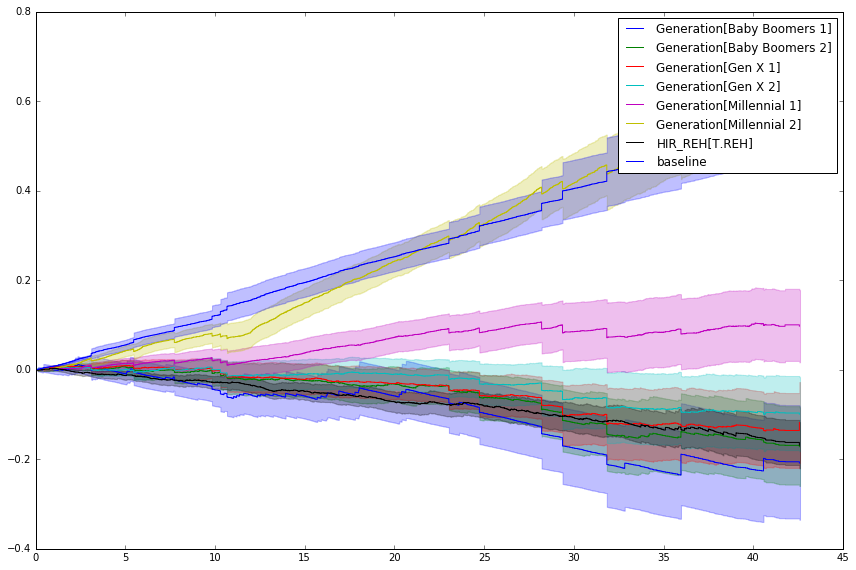

In [8]:

aaf.plot(columns=['Generation[Baby Boomers 1]', 'Generation[Baby Boomers 2]', 'Generation[Gen X 1]', 'Generation[Gen X 2]', 'Generation[Millennial 1]', 'Generation[Millennial 2]', 'HIR_REH[T.REH]', 'baseline'])
plt.tight_layout(rect=(2,2,4,4))

In [9]:
B = patsy.dmatrix('Generation * GENDER * HIR_REH -1', df, return_type='dataframe')
B.columns


aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
B['T'] = df['Duration']/30
B['E'] = df['Event']
aaf.fit(B, 'T', event_col='E')

 [-----------------100%-----------------] 14905 of 14905 complete in 250.7 sec


<lifelines.AalenAdditiveFitter: fitted with 51623 observations, 36718 censored>

In [10]:
print aaf.cumulative_hazards_.head()

          Generation[Baby Boomers 1]  Generation[Baby Boomers 2]  \
0.033333                   -0.000325                   -0.000327   
0.066667                   -0.000561                   -0.000581   
0.100000                   -0.001245                    0.000453   
0.133333                   -0.001409                   -0.000208   
0.166667                   -0.001552                   -0.000358   

          Generation[Gen X 1]  Generation[Gen X 2]  Generation[Gen Z]  \
0.033333            -0.000327             0.001618          -0.000296   
0.066667            -0.000581             0.002012          -0.000526   
0.100000            -0.000438             0.003200          -0.001207   
0.133333             0.002500             0.003193          -0.002172   
0.166667             0.003249             0.003043          -0.002307   

          Generation[Millennial 1]  Generation[Millennial 2]  GENDER[T.M]  \
0.033333                  0.000028                 -0.000045    -0.000010  

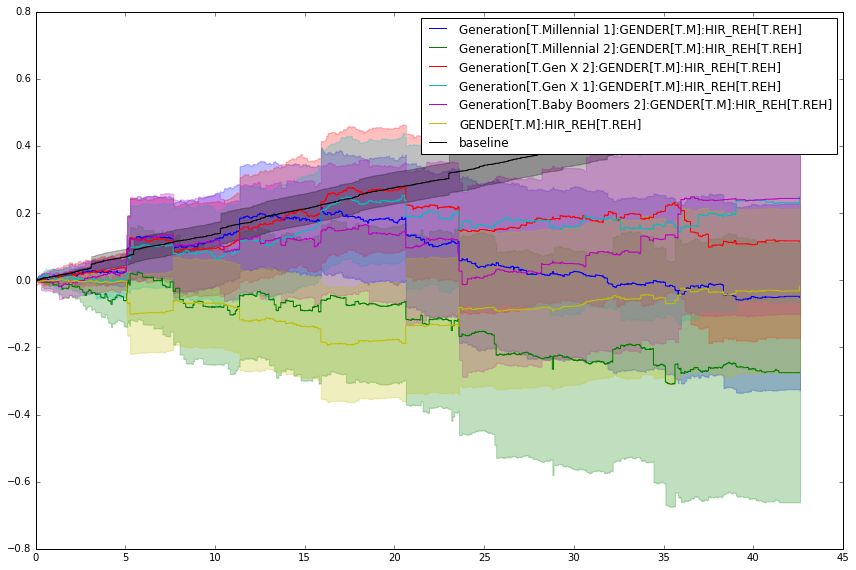

In [11]:
aaf.plot(columns=['Generation[T.Millennial 1]:GENDER[T.M]:HIR_REH[T.REH]', 'Generation[T.Millennial 2]:GENDER[T.M]:HIR_REH[T.REH]',
                 'Generation[T.Gen X 2]:GENDER[T.M]:HIR_REH[T.REH]', 'Generation[T.Gen X 1]:GENDER[T.M]:HIR_REH[T.REH]',
                 'Generation[T.Baby Boomers 2]:GENDER[T.M]:HIR_REH[T.REH]', 'GENDER[T.M]:HIR_REH[T.REH]', 'baseline'])
plt.tight_layout(rect=(2,2,4,4))



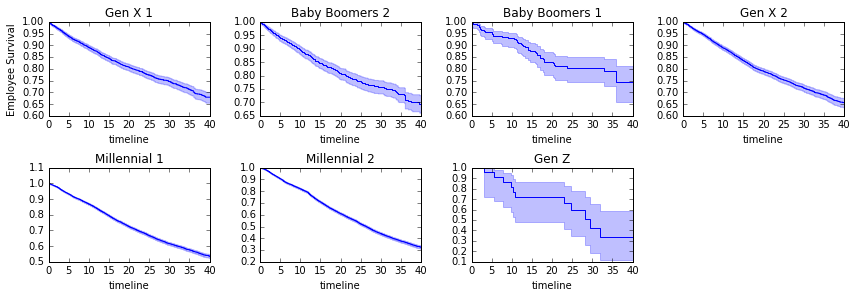

In [17]:
kmf = KaplanMeierFitter()
Generations = df['Generation'].unique()
D = df['Duration']/30
C = df['Event']
for i,Generations in enumerate(Generations):
    ax = plt.subplot(4,4,i+1)
    ix = df['Generation'] == Generations
    kmf.fit( D[ix], C[ix], label=Generations )
    kmf.plot(ax=ax, legend=False)
    plt.title(Generations)
    plt.xlim(0,40)
    if i==0:
        plt.ylabel('Employee Survival')
plt.tight_layout(rect=(4,4,6,6))

In [18]:
df.columns

Index([u'BADGE', u'GENDER', u'HIRE_DATE', u'Duration', u'age_at_hire',
       u'COUNTRY', u'HIR_REH', u'GRADE_AT_HIRE', u'FUNCTION_AT_HIRE',
       u'CURRENT_FUNCTION', u'CURRENT_GRADE', u'Event', u'TERMINATION_CODE',
       u'TERMINATION_REASON', u'ACTION', u'DIT_FUNC_VP_NAME',
       u'DIT_2LVL_VP_NAME', u'Generation', u'Generation_Baby Boomers 1',
       u'Generation_Baby Boomers 2', u'Generation_Gen X 1',
       u'Generation_Gen X 2', u'Generation_Gen Z', u'Generation_Millennial 1',
       u'Generation_Millennial 2'],
      dtype='object')

In [19]:
#binning my grades for grade at hire and current grade to 
# match the 6 bin system (ind contributor, ICP, Sr. ICP, Mgr, SMgr, Exec) instead
# of the more complicated grade level system with 16 levels (to avoid so many dummies later)

def bin_grade(x):
    if(x == np.nan or x == None):
        return 'Null' 
        
    if x in ['EF', 'EG', 'EI', 'EJ', 'IK', 'IL']:
        return 'exec'
    elif x in ['MD', 'ME']:
        return 'smgr'
    elif x in ['MA', 'MB', 'MC']:
        return 'mgr'
    elif x in ['II', 'IJ']:
        return 'icsp'    
    elif x in ['IF', 'IG', 'IH']:
        return 'icp'
    else:
        return 'ic'
    
    
df['Career_Band_Hire'] = df.GRADE_AT_HIRE.apply(bin_grade)
df['Career_Band_Current'] = df.CURRENT_GRADE.apply(bin_grade)

In [20]:
df_dummy_grades = pd.get_dummies(df.Career_Band_Hire).rename(
    columns=lambda x: 'Career_Band_Hire_' + str(x)
)
df_dummy_grades_2 = pd.get_dummies(df.Career_Band_Current).rename(
    columns=lambda x: 'Career_Band_Current_' + str(x)
)
df_dummy_function_hire = pd.get_dummies(df.FUNCTION_AT_HIRE).rename(
    columns=lambda x: 'FUNCTION_AT_HIRE_' + str(x)
)
df_dummy_function_current = pd.get_dummies(df.CURRENT_FUNCTION).rename(
    columns=lambda x: 'CURRENT_FUNCTION_' + str(x)
)
df_dummy_gender = pd.get_dummies(df.GENDER).rename(
    columns=lambda x: 'GENDER_' + str(x)
)
df_dummy_country = pd.get_dummies(df.COUNTRY)
df_hire_rehire = pd.get_dummies(df.HIR_REH)

In [21]:
df1 = df.join([df_dummy_grades, df_dummy_grades_2, df_dummy_function_hire, df_dummy_function_current, df_dummy_gender, df_dummy_country, df_hire_rehire])
#df2 = df1.join(df_dummy_grades_2)
#df3 = df2.join(df_dummy_function_hire)
#df4 = df3.join(df_dummy_function_current)

#variables I will drop include HIRE gender M, country SWE, function current AC, function hire AC, grade hire IA, grade current IA

D = df1['Duration']/30
C = df1['Event']

del df1['GENDER_M']
del df1['SWE']
del df1['CURRENT_FUNCTION_AC']
del df1['FUNCTION_AT_HIRE_AC']
del df1['Career_Band_Current_ic']
del df1['Career_Band_Hire_ic']
del df1['HIR']
del df1['GENDER']
del df1['FUNCTION_AT_HIRE']
del df1['Career_Band_Current']
del df1['CURRENT_GRADE']
del df1['GRADE_AT_HIRE']
del df1['CURRENT_FUNCTION']
del df1['Career_Band_Hire']
del df1['HIR_REH']
del df1['HIRE_DATE']
del df1['Event']
del df1['Duration']
del df1['Generation']
# deleting specific columns for the n-1 dummies rule

In [22]:
df1.columns

Index([u'BADGE', u'age_at_hire', u'COUNTRY', u'TERMINATION_CODE',
       u'TERMINATION_REASON', u'ACTION', u'DIT_FUNC_VP_NAME',
       u'DIT_2LVL_VP_NAME', u'Generation_Baby Boomers 1',
       u'Generation_Baby Boomers 2',
       ...
       u'SAU', u'SGP', u'SLV', u'SVK', u'THA', u'TUR', u'TWN', u'USA', u'ZAF',
       u'REH'],
      dtype='object', length=154)

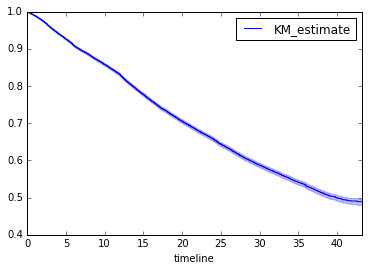

In [23]:
# Kaplan Meier ...just a survival analysis on event and duration
kmf = KaplanMeierFitter()
kmf.fit(D, event_observed=C) # more concise => kmf.fit(D,C)
kmf.survival_function_
kmf.median_
kmf.plot()


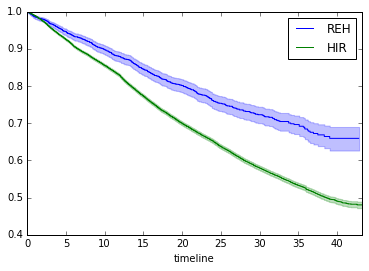

In [24]:

# Grouping by Hires (new hire/first time hired) vs Rehired (previous employees returning)

T = df['Duration']/30
E = df['Event']

groups = df['HIR_REH']
ix = (groups == 'HIR')

kmf.fit(T[~ix], E[~ix], label='REH')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='HIR')
kmf.plot(ax=ax)





Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            123.406 |      Reject Null    |        True       


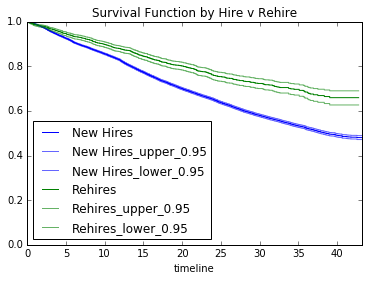

In [25]:
ax = plt.subplot(111)

hire_type = (df['HIR_REH'] == "HIR")
kmf.fit(T[hire_type], event_observed=C[hire_type], label='New Hires')
kmf.plot(ax = ax, ci_force_lines=True)

kmf.fit(T[~hire_type], event_observed=C[~hire_type], label='Rehires')
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0,1);
plt.title("Survival Function by Hire v Rehire")


from lifelines.statistics import logrank_test

results = logrank_test(T[hire_type], T[~hire_type], E[hire_type], E[~hire_type], alpha=.99 )

results.print_summary()

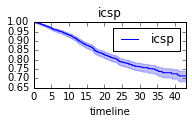

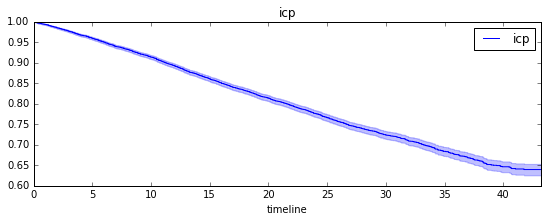

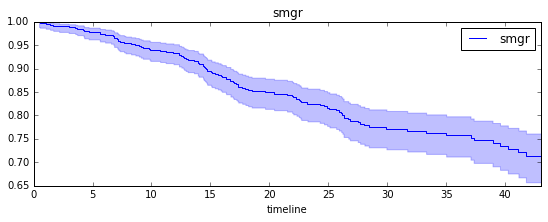

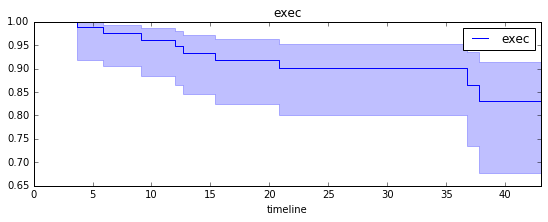

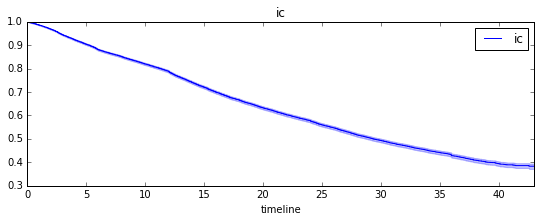

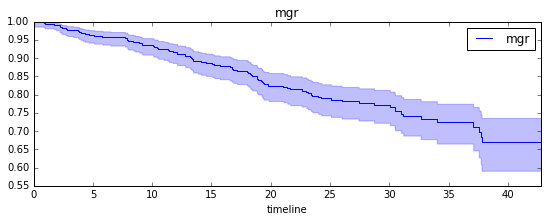

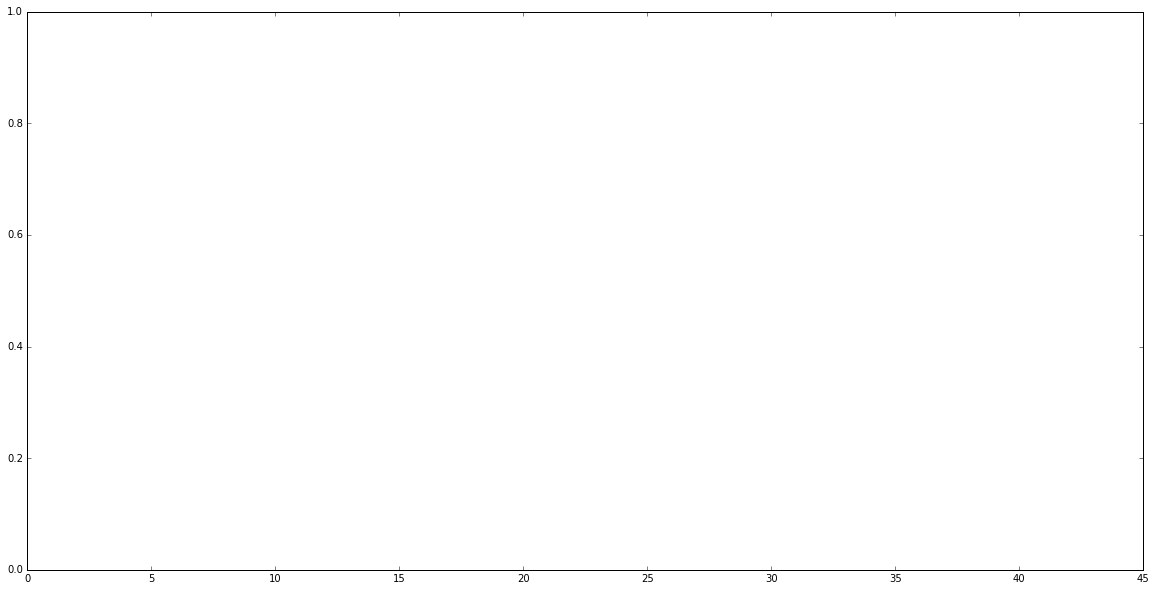

In [38]:
hire_grade_levels = df['Career_Band_Hire'].unique()

for i,hire_grade_level in enumerate(hire_grade_levels):
    ax = plt.subplot(3,2,1)
    ix = df['Career_Band_Hire'] == hire_grade_level
    kmf.fit( T[ix], E[ix], label=hire_grade_level )
    kmf.plot(ax=ax, legend=True)
    plt.title(hire_grade_level)
    plt.figure(figsize=(20,10))
    plt.xlim(0,45)
    



In [39]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(D, event_observed=C)

<lifelines.NelsonAalenFitter: fitted with 51623 observations, 36718 censored>

In [40]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(D, C)
print table.head(10)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.000000        0         0         0     51623    51623
0.033333       38        12        26         0    51623
0.066667       26        18         8         0    51585
0.100000       37        35         2         0    51559
0.133333       69        24        45         0    51522
0.166667       19         6        13         0    51453
0.200000      226        10       216         0    51434
0.233333       24        24         0         0    51208
0.266667       30        30         0         0    51184
0.300000       27        27         0         0    51154


In [41]:
df1.count()

BADGE                        51623
age_at_hire                  51623
COUNTRY                      51623
TERMINATION_CODE             14905
TERMINATION_REASON           14905
ACTION                       14905
DIT_FUNC_VP_NAME             51623
DIT_2LVL_VP_NAME             51623
Generation_Baby Boomers 1    51623
Generation_Baby Boomers 2    51623
Generation_Gen X 1           51623
Generation_Gen X 2           51623
Generation_Gen Z             51623
Generation_Millennial 1      51623
Generation_Millennial 2      51623
Career_Band_Hire_exec        51623
Career_Band_Hire_icp         51623
Career_Band_Hire_icsp        51623
Career_Band_Hire_mgr         51623
Career_Band_Hire_smgr        51623
Career_Band_Current_exec     51623
Career_Band_Current_icp      51623
Career_Band_Current_icsp     51623
Career_Band_Current_mgr      51623
Career_Band_Current_smgr     51623
FUNCTION_AT_HIRE_BP          51623
FUNCTION_AT_HIRE_CC          51623
FUNCTION_AT_HIRE_CT          51623
FUNCTION_AT_HIRE_DE 

In [42]:
# Nelson Aalen's Estimator (non-parametric cumulative hazard rate function, using it here
# to account for the right censored data)
naf = NelsonAalenFitter()
naf.fit(D, event_observed=C)

<lifelines.NelsonAalenFitter: fitted with 51623 observations, 36718 censored>

          NA_estimate
timeline             
0.000000     0.000000
0.033333     0.000232
0.066667     0.000581
0.100000     0.001261
0.133333     0.001726


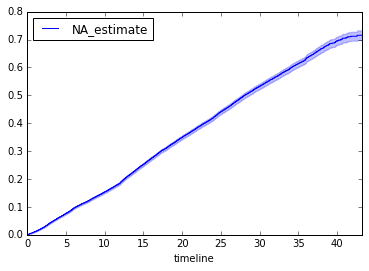

In [43]:
print naf.cumulative_hazard_.head()
naf.plot()

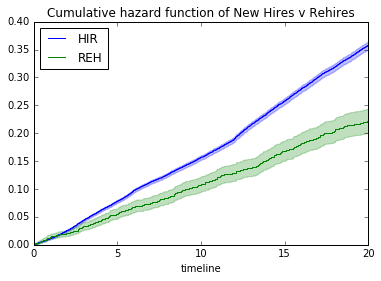

In [44]:
naf.fit(T[hire_type], event_observed=C[hire_type], label="HIR")
ax = naf.plot(ix=slice(0,20))
naf.fit(T[~hire_type], event_observed=C[~hire_type], label="REH")
naf.plot(ax=ax, ix=slice(0,20))
plt.title("Cumulative hazard function of New Hires v Rehires");


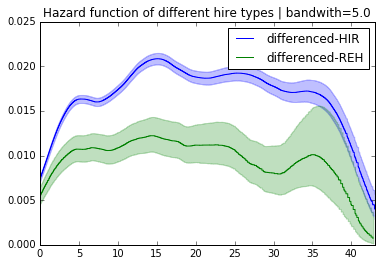

In [45]:
# this is an experimental approach 
b = 5.
naf.fit(T[hire_type], event_observed=C[hire_type], label="HIR")
ax = naf.plot_hazard(bandwidth=b)
naf.fit(T[~hire_type], event_observed=C[~hire_type], label="REH")
naf.plot_hazard(ax=ax, bandwidth=b)
plt.title("Hazard function of different hire types | bandwith=%.1f"%b);
plt.ylim(0,0.025)
plt.xlim(0,43);

In [77]:
import statsmodels.formula.api as smf

data = pd.read_csv("C:\Users\Zane_Harris\Desktop\HRIS files\HRIS\Attrition Study\Primary Data\Global_Base_IBP_STI_Rollup_November2015.csv")

    
data['Generation'] = data.age_at_hire.apply(bin_age)

data_dummy_generation = pd.get_dummies(data.Generation).rename(
    columns=lambda x: 'Generation_' + str(x)
)
data_dummy_gender = pd.get_dummies(data.GENDER).rename(
    columns=lambda x: 'GENDER_' + str(x)
)

data = data.join(data_dummy_gender)
data.head()

,BADGE,NAME,BIRTHDATE,GENDER,HIRE_DATE,Duration,age_at_hire,COUNTRY,HIR_REH,JOBCODE_AT_HIRE,...,DIT_FUNC_DIR_ID,DIT_FUNC_DIR_NAME,DIT_FUNC_VP_ID,DIT_FUNC_VP_NAME,DIT_2LVL_VP_ID,DIT_2LVL_VP_NAME,Generation,GENDER_F,GENDER_M,GENDER_U
0,100973,"Taylor Petersen, Rebecca Jane",3/19/1975,F,12/10/2012,461,37,AUS,HIR,ADS402,...,950329,"See, Peter",910294,"Ansah, Michael",15042,"Price, Steve H.",Gen X 2,1,0,0
1,101177,"Piera, Tomasz",7/24/1966,M,10/15/2012,714,46,POL,REH,PAM101,...,,,88295,"Li, York",308394,"Dundas, Michael Blaine",Gen X 1,0,1,0
2,104847,"Geary, Suzanne",5/28/1973,F,10/26/2012,12,39,IRL,REH,PNE800,...,304310,"Patanella, Todd Earl",175606,"Poljan, Patrick",22072,"Brown, Kevin M.",Gen X 2,1,0,0
3,10623,"Braselton, Tom C.",2/21/1971,M,9/10/2012,958,41,USA,REH,SDV800,...,535813,"Raghavan, Veera S",364711,"Nair, Sid",353428,"Vaswani, Suresh",Gen X 2,0,1,0
4,107585,"Boland, Mike",6/18/1973,M,3/19/2013,375,39,IRL,REH,PGV801,...,,,536680,"Ramamurthy, Ramakrishnan",674834,"Thrikutam, Prasad",Gen X 2,0,1,0


In [78]:
print data.columns

Index([u'BADGE', u'NAME', u'BIRTHDATE', u'GENDER', u'HIRE_DATE', u'Duration',
       u'age_at_hire', u'COUNTRY', u'HIR_REH', u'JOBCODE_AT_HIRE',
       u'TITLE_AT_HIRE', u'GRADE_AT_HIRE', u'FUNCTION_AT_HIRE',
       u'BASE_AT_HIRE', u'STI_AT_HIRE', u'IBP_TGT_AT_HIRE', u'CURRENT_JOBCODE',
       u'CURRENT_TITLE', u'CURRENT_FUNCTION', u'CURRENT_GRADE',
       u'CURRENT_JOB_ENTRY_DT', u'CURRENT_GRADE_ENTRY_DT', u'CURRENT_BASE',
       u'CURRENT_STI', u'CURRENT_IBP_TGT', u'CURRENT_STATUS',
       u'FUNCTION CHANGE?', u'BASE CHANGE %', u'STI CHANGE %',
       u'DAILY BASE CHANGE %', u'DAILY STI CHANGE %', u'IBP TARGET CHANGE %',
       u'DAILY IBP TARGET CHANGE %', u'TERMINATION_DATE', u'TERMINATION_CODE',
       u'TERMINATION_REASON', u'ACTION', u'Event', u'PROMO_COUNT',
       u'LATERAL_COUNT', u'SUPERVISOR_ID', u'Sup IL FY15 DR',
       u'Sup IL FY15 Org', u'DIT_SUP_PNAME', u'DIT_LVL2_SUP_ID',
       u'DIT_LVL2_SUP_NAME', u'DIT_LVL3_SUP_ID', u'DIT_LVL3_SUP_NAME',
       u'DIT_FUNC_DIR_ID

In [90]:
def bin_base_change(x):
    if x < 0:
        return 'Negative'
    elif x > 0:
        return x
    else:
        return 0
   
    
data['BASE_CHANGE'] = data['BASE CHANGE %'].map(bin_base_change)

data.dtypes

BADGE                          int64
NAME                          object
BIRTHDATE                     object
GENDER                        object
HIRE_DATE                     object
Duration                       int64
age_at_hire                    int64
COUNTRY                       object
HIR_REH                       object
JOBCODE_AT_HIRE               object
TITLE_AT_HIRE                 object
GRADE_AT_HIRE                 object
FUNCTION_AT_HIRE              object
BASE_AT_HIRE                 float64
STI_AT_HIRE                  float64
IBP_TGT_AT_HIRE              float64
CURRENT_JOBCODE               object
CURRENT_TITLE                 object
CURRENT_FUNCTION              object
CURRENT_GRADE                 object
CURRENT_JOB_ENTRY_DT          object
CURRENT_GRADE_ENTRY_DT        object
CURRENT_BASE                 float64
CURRENT_STI                  float64
CURRENT_IBP_TGT              float64
CURRENT_STATUS                object
FUNCTION CHANGE?               int64
B

In [85]:

lm_stats = smf.ols(formula='Event ~ Duration + Generation + HIR_REH', data=data).fit()
lm_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Event   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     15.95
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        20:35:17   Log-Likelihood:                -31149.
No. Observations:               52799   AIC:                         6.279e+04
Df Residuals:                   52554   BIC:                         6.496e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                        0.2665      0.140      1.900      0.057        -0.008     0.542
Generation[T.Baby Boomers 2]     0.0389      0.024      1.603      0.109        -0.009     0.087
Generation[T.Gen X 1]            0.0502      0.023      2.168      0.030         0.005     0.096
Generation[T.Gen X 2]            0.0504      0.023      2.204      0.028         0.006     0.095
Generation[T.Gen Z]              0.3288      0.091      3.621      0.000         0.151     0.507
Generation[T.Millennial 1]       0.1125      0.022      5.009      0.000         0.068     0.156
Generation[T.Millennial 2]       0.1922      0.023      8.497      0.000         0.148     0.236
HIR_REH[T.REH]                  -0.0665      0.008     -8.550      0.000        -0.082    -0.051
BASE_CHANGE[T.-10%]              0.1233      0.167      0.739      0.460        -0.204     0.450
BASE_CHANGE[T.-100%]             0.0104      0.140      0.074      0.941        -0.264     0.285
BASE_CHANGE[T.-11%]              0.0368      0.163      0.226      0.821        -0.282     0.356
BASE_CHANGE[T.-12%]              0.1311      0.208      0.632      0.527        -0.276     0.538
BASE_CHANGE[T.-13%]             -0.2043      0.179     -1.144      0.253        -0.554     0.146
BASE_CHANGE[T.-14%]             -0.0358      0.201     -0.178      0.859        -0.430     0.358
BASE_CHANGE[T.-15%]              0.2493      0.196      1.274      0.203        -0.134     0.633
BASE_CHANGE[T.-16%]             -0.0351      0.208     -0.169      0.866        -0.442     0.372
BASE_CHANGE[T.-17%]              0.0032      0.226      0.014      0.989        -0.440     0.446
BASE_CHANGE[T.-18%]             -0.1583      0.208     -0.763      0.446        -0.565     0.248
BASE_CHANGE[T.-19%]              0.0560      0.201      0.279      0.780        -0.338     0.450
BASE_CHANGE[T.-2%]              -0.0577      0.171     -0.338      0.736        -0.393     0.277
BASE_CHANGE[T.-20%]             -0.0443      0.208     -0.213      0.831        -0.451     0.362
BASE_CHANGE[T.-21%]              0.1033      0.201      0.514      0.607        -0.291     0.497
BASE_CHANGE[T.-22%]              0.1426      0.226      0.631      0.528        -0.300     0.585
BASE_CHANGE[T.-23%]             -0.1011      0.288     -0.351      0.726        -0.666     0.463
BASE_CHANGE[T.-24%]             -0.0367      0.459     -0.080      0.936        -0.936     0.863
BASE_CHANGE[T.-25%]              0.1632      0.208      0.786      0.432        -0.244     0.570
BASE_CHANGE[T.-26%]              0.0638      0.196      0.326      0.744        -0.320     0.447
BASE_CHANGE[T.-27%]              0.0308      0.240      0.128      0.898        -0.439     0.501
BASE_CHANGE[T.-28%]             -0.0732      0.181     -0.404      0.686    